In [1]:
# Import all the required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import re
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Import the random forest classifier - This is a classification problem and I think this is the best model for prediction
#from scipy.stats import randint
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import compose
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
catg_feature_names = [
    'funder',
    'basin',
#    'region',                    
#    'district_code',
    'lga',
    'scheme_management',
    'extraction_type',
    'extraction_type_class',
    'management',
    'payment_type',
    'water_quality',
    'quantity',
    'source',     
    'source_class',
#    'waterpoint_type_group'
]

num_feature_names = [
#    'amount_tsh',
#    'gps_height',
    'longitude',
    'latitude',
#    'population',
    'construction_year',
    'pump_age'
]

date_feature_names = [
#    'date_recorded',
    'year_rec',
    'week_rec',
    'day_rec'
]

label_names = ['status_group']

In [4]:
# Load the cleaned dataset and view the first few rows
df = pd.read_csv('data/cleaned_df_v2.csv', usecols= ['date_recorded'] + catg_feature_names + num_feature_names + label_names)
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date_recorded          59400 non-null  datetime64[ns]
 1   funder                 59400 non-null  object        
 2   longitude              59400 non-null  float64       
 3   latitude               59400 non-null  float64       
 4   basin                  59400 non-null  object        
 5   lga                    59400 non-null  object        
 6   scheme_management      59400 non-null  object        
 7   construction_year      59400 non-null  float64       
 8   extraction_type        59400 non-null  object        
 9   extraction_type_class  59400 non-null  object        
 10  management             59400 non-null  object        
 11  payment_type           59400 non-null  object        
 12  water_quality          59400 non-null  object        
 13  q

In [5]:
# Adding date features...
df['year_rec'] = df['date_recorded'].apply(lambda x: pd.to_datetime(x).date().isocalendar()[0])
df['week_rec'] = df['date_recorded'].apply(lambda x: pd.to_datetime(x).date().isocalendar()[1])
df['day_rec'] = df['date_recorded'].apply(lambda x: pd.to_datetime(x).date().isocalendar()[2])
df.drop('date_recorded', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 59400 non-null  object 
 1   longitude              59400 non-null  float64
 2   latitude               59400 non-null  float64
 3   basin                  59400 non-null  object 
 4   lga                    59400 non-null  object 
 5   scheme_management      59400 non-null  object 
 6   construction_year      59400 non-null  float64
 7   extraction_type        59400 non-null  object 
 8   extraction_type_class  59400 non-null  object 
 9   management             59400 non-null  object 
 10  payment_type           59400 non-null  object 
 11  water_quality          59400 non-null  object 
 12  quantity               59400 non-null  object 
 13  source                 59400 non-null  object 
 14  source_class           59400 non-null  object 
 15  st

### Reducing the levels and transformation of categorical data
The levels of some of the categorical variables were reduced to keep a manageable number of features. Small-size levels were grouped into a separate level named 'OTHERS':

In [6]:
#top_ith = 10 # Maximum levels to keep for categorical variables

for catg_feature in catg_feature_names:
    unique_percent_counts = df[catg_feature].value_counts()
    
    top_frequent_indexes = unique_percent_counts[:10-1].index.values.tolist()
    x = df[catg_feature].copy()
    x[~x.isin(top_frequent_indexes)] = 'OTHER'
    
    df.loc[:,catg_feature] = x
    df[catg_feature].value_counts()

In [7]:
df.funder.value_counts()

OTHER                     35052
government of tanzania     9084
Unknown                    3635
danida                     3114
hesawa                     2202
rwssp                      1374
world bank                 1349
kkkt                       1287
world vision               1246
unicef                     1057
Name: funder, dtype: int64

In [8]:
catg_feature_names

['funder',
 'basin',
 'lga',
 'scheme_management',
 'extraction_type',
 'extraction_type_class',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'source_class']

In [9]:
df.funder.unique()

array(['OTHER', 'unicef', 'rwssp', 'danida', 'world vision', 'hesawa',
       'government of tanzania', 'Unknown', 'kkkt', 'world bank'],
      dtype=object)

In [10]:
df.basin.unique()

array(['lake nyasa', 'lake victoria', 'pangani',
       'ruvuma / southern coast', 'internal', 'lake tanganyika',
       'wami / ruvu', 'rufiji', 'lake rukwa'], dtype=object)

In [11]:
df.extraction_type.unique()

array(['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii',
       'other', 'ksb', 'mono', 'OTHER', 'afridev'], dtype=object)

In [12]:
#df.district_code.unique()

In [13]:
#df.loc[:,catg_feature_names]

In [14]:
# Transform and combine categorical and numerical features:
catg_transformer = compose.ColumnTransformer(
    transformers=
    [
     ('catg', preprocessing.OneHotEncoder(), catg_feature_names),
    ],
    #remainder='drop',
    sparse_threshold=0.0,
    #n_jobs=None,
    transformer_weights=None,
    #verbose=False
)

catg_transformer.fit(df.loc[:,catg_feature_names])

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.0,
         transformer_weights=None,
         transformers=[('catg', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True), ['funder', 'basin', 'lga', 'scheme_management', 'extraction_type', 'extraction_type_class', 'management', 'payment_type', 'water_quality', 'quantity', 'source', 'source_class'])])

In [15]:
#catg_transformer.transformers_

In [16]:
#onehot_encoder.get_feature_names()

In [17]:
def get_name_and_levels(onehot_encoder: compose.ColumnTransformer , catg_names):
    """
    Gets 'transformed catg feature' names from compose.ColumnTransformer object and catg feature names.

    """
    onehot_feature_names = onehot_encoder.get_feature_names()

    f_name_and_level = [catg_names[int(re.search(r'\d+', elm).group())]
                        + '-' + elm.split('__', 1)[-1].split('_', 1)[-1]
                        for elm in onehot_feature_names
                        ]
    return f_name_and_level


catg_features_trans = catg_transformer.transform(df.loc[:, catg_feature_names])
catg_feature_trans_names = get_name_and_levels(catg_transformer, catg_feature_names)
num_features = df.loc[:, num_feature_names]
date_features = df.loc[:, date_feature_names]
# num_feature_trans_names = None

X_trans = np.concatenate([catg_features_trans, num_features, date_features], axis=1)
X_trans_names = catg_feature_trans_names + num_feature_names + date_feature_names
y = df.loc[:,label_names].values

In [18]:
y_true = [1 if x == 'functional' else 0 for x in y]
y_true

[1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,


In [19]:
catg_feature_trans_names

['funder-OTHER',
 'funder-Unknown',
 'funder-danida',
 'funder-government of tanzania',
 'funder-hesawa',
 'funder-kkkt',
 'funder-rwssp',
 'funder-unicef',
 'funder-world bank',
 'funder-world vision',
 'basin-internal',
 'basin-lake nyasa',
 'basin-lake rukwa',
 'basin-lake tanganyika',
 'basin-lake victoria',
 'basin-pangani',
 'basin-rufiji',
 'basin-ruvuma / southern coast',
 'basin-wami / ruvu',
 'lga-OTHER',
 'lga-arusha rural',
 'lga-bariadi',
 'lga-kasulu',
 'lga-kilosa',
 'lga-mbozi',
 'lga-meru',
 'lga-moshi rural',
 'lga-njombe',
 'lga-rungwe',
 'scheme_management-OTHER',
 'scheme_management-Unknown',
 'scheme_management-company',
 'scheme_management-parastatal',
 'scheme_management-private operator',
 'scheme_management-vwc',
 'scheme_management-water authority',
 'scheme_management-water board',
 'scheme_management-wua',
 'scheme_management-wug',
 'extraction_type-OTHER',
 'extraction_type-afridev',
 'extraction_type-gravity',
 'extraction_type-india mark ii',
 'extractio

In [20]:
df.loc[:, catg_feature_names]

,funder,basin,lga,scheme_management,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class
0,OTHER,lake nyasa,OTHER,vwc,gravity,gravity,vwc,annually,soft,enough,spring,groundwater
1,OTHER,lake victoria,OTHER,OTHER,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface
2,OTHER,pangani,OTHER,vwc,gravity,gravity,vwc,per bucket,soft,enough,dam,surface
3,unicef,ruvuma / southern coast,OTHER,vwc,submersible,submersible,vwc,never pay,soft,dry,machine dbh,groundwater
4,OTHER,lake victoria,OTHER,Unknown,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface
...,...,...,...,...,...,...,...,...,...,...,...,...
59395,OTHER,pangani,OTHER,water board,gravity,gravity,water board,per bucket,soft,enough,spring,groundwater
59396,OTHER,rufiji,njombe,vwc,gravity,gravity,vwc,annually,soft,enough,river,surface
59397,Unknown,rufiji,OTHER,vwc,swn 80,handpump,vwc,monthly,fluoride,enough,machine dbh,groundwater
59398,OTHER,rufiji,OTHER,vwc,nira/tanira,handpump,vwc,never pay,soft,insufficient,shallow well,groundwater


In [21]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_true, test_size=0.3, random_state=42)

In [22]:
# Training Decision Tree Classifier Model
modelDTC = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=15,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight='balanced',
    presort=False)

modelDTC.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=15,
            splitter='best')

In [23]:
# Accuracy score for Decision Tree
y_pred = modelDTC.predict(X_test)
scoreDTC = accuracy_score(y_pred, y_test)
print('Decision Tree Classifier accuracy: {:.2f}'.format(scoreDTC))

Decision Tree Classifier accuracy: 0.71


In [24]:
# Using GridSearchCV on DecisionTreeClassifier
#create a dictionary of all values we want to test
param_dist = {"max_depth": np.arange(1, 21),
              #"max_features": randint(1, 9),
              "min_samples_leaf": [1, 5, 10, 20, 50, 100],
              #"criterion": ["gini", "entropy"]
             }
#use gridsearch to test all values
tree_cv = GridSearchCV(modelDTC, param_dist, cv=5)
#fit model to data
tree_cv.fit(X_train, y_train)
print(tree_cv.best_params_)
print(accuracy_score(tree_cv.predict(X_test), y_test))

{'max_depth': 20, 'min_samples_leaf': 1}
0.7834455667789001


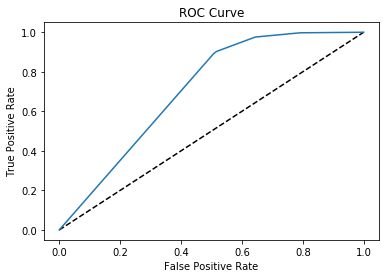

In [25]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = modelDTC.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [26]:
# Compute and print AUC score
# If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(modelDTC, X_trans, y_true, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.7080420596608692
AUC scores computed using 5-fold cross-validation: [0.71234051 0.69927621 0.7043076  0.70590238 0.71432597]


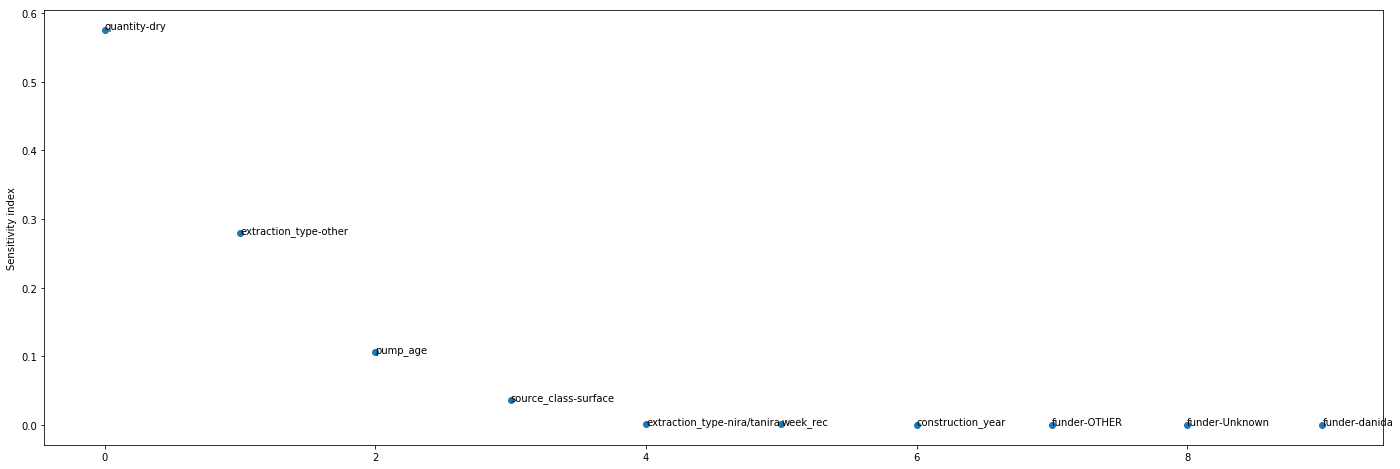

In [27]:
# Plotting most important features
num_top_features = 10
feature_importance = modelDTC.feature_importances_

sorted_f_importance = sorted(zip(X_trans_names, feature_importance),
                             key=lambda x:x[-1],
                             reverse=True)
fig, axe = plt.subplots(1,1)
axe.plot([elm[-1] for elm in sorted_f_importance][:num_top_features], 'o')

for (id, (f_name, f_importance)) in enumerate(sorted_f_importance[:num_top_features]):
    axe.annotate('{}'.format(f_name),xy=(id, f_importance))
axe.set_ylabel('Sensitivity index')
fig = plt.gcf()
fig.set_size_inches(24,8)

In [28]:
# Training Random Forest Classifier Model
modelRFC = RandomForestClassifier(n_estimators=200, min_samples_split=10, criterion='gini')
modelRFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
# Accuracy score for Random Forest
y_pred = modelRFC.predict(X_test)
scoreRFC = accuracy_score(y_pred, y_test)
print('Random Forest Classifier Accuracy: {:.2f}'.format(scoreRFC))

Random Forest Classifier Accuracy: 0.82


In [30]:
# Using GridSearchCV on RandomForestClassifier
#create a dictionary of all values we want to test
param_dist = {"max_depth": np.arange(1, 21),
              #"max_features": randint(1, 9),
              "min_samples_leaf": [1, 5, 10, 20, 50, 100],
              #"criterion": ["gini", "entropy"]
             }
#use gridsearch to test all values
rf_cv = GridSearchCV(modelRFC, param_dist, cv=5)
#fit model to data
rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1}


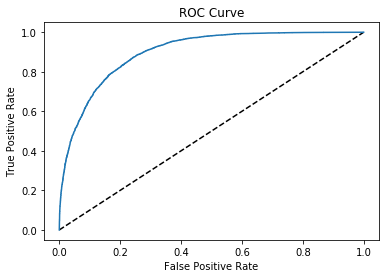

In [31]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = modelRFC.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [32]:
# Compute and print AUC score
# If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(modelRFC, X_trans, y_true, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.8987481998209881
AUC scores computed using 5-fold cross-validation: [0.90253663 0.89647484 0.90087073 0.89606126 0.89827107]


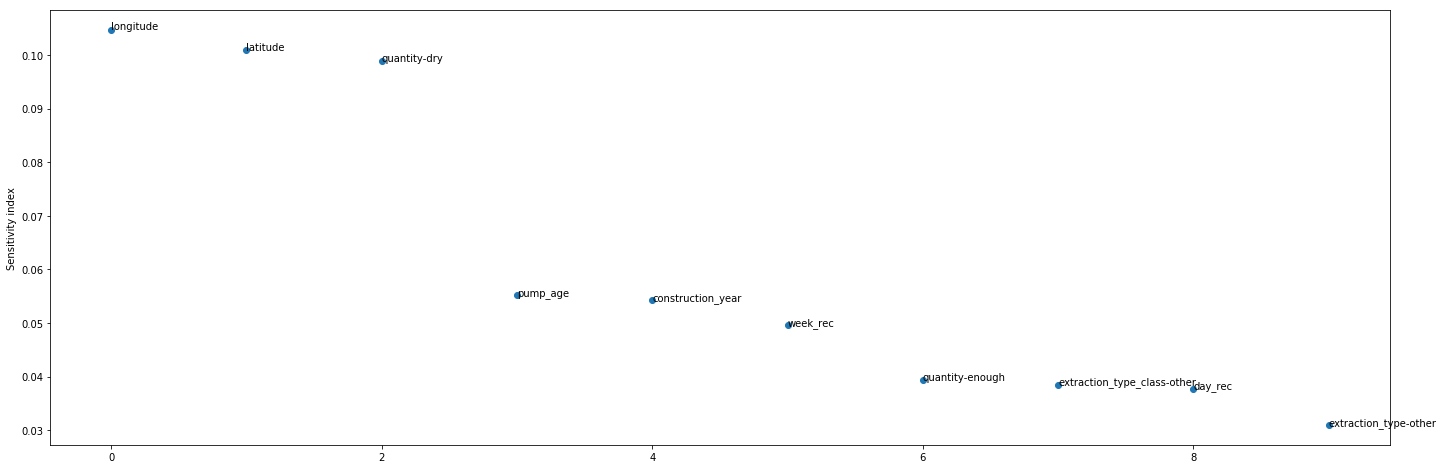

In [33]:
# Plotting most important features
num_top_features = 10
feature_importance = modelRFC.feature_importances_

sorted_f_importance = sorted(zip(X_trans_names, feature_importance),
                             key=lambda x:x[-1],
                             reverse=True)
fig, axe = plt.subplots(1,1)
axe.plot([elm[-1] for elm in sorted_f_importance][:num_top_features], 'o')

for (id, (f_name, f_importance)) in enumerate(sorted_f_importance[:num_top_features]):
    axe.annotate('{}'.format(f_name),xy=(id, f_importance))
axe.set_ylabel('Sensitivity index')
fig = plt.gcf()
fig.set_size_inches(24,8)

In [34]:
# Training Extra Trees Classifier Model
modelETC = ExtraTreesClassifier(n_estimators=100,min_samples_split=10)
modelETC.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
# Accuracy score for Extra Trees
y_pred = modelRFC.predict(X_test)
scoreETC = accuracy_score(y_pred, y_test)
print('Extra Trees Classifier Accuracy: {:.2f}'.format(scoreETC))

Extra Trees Classifier Accuracy: 0.82


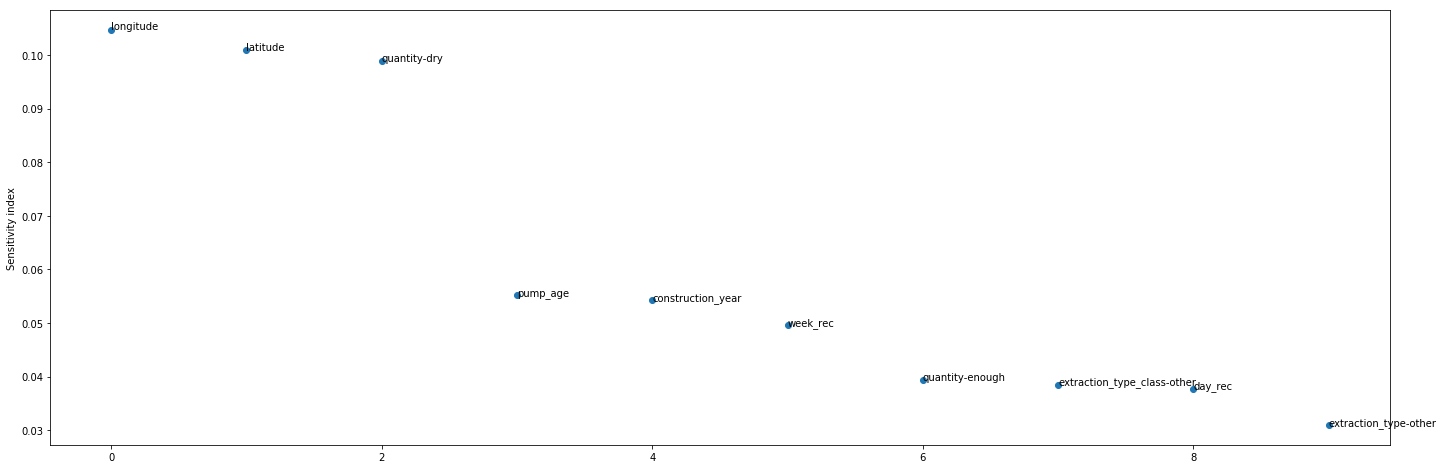

In [36]:
# Plotting most important features
num_top_features = 10
feature_importance = modelETC.feature_importances_

feature_importances_sorted_f_importance = sorted(zip(X_trans_names, feature_importance),
                             key=lambda x:x[-1],
                             reverse=True)
fig, axe = plt.subplots(1,1)
axe.plot([elm[-1] for elm in sorted_f_importance][:num_top_features], 'o')

for (id, (f_name, f_importance)) in enumerate(sorted_f_importance[:num_top_features]):
    axe.annotate('{}'.format(f_name),xy=(id, f_importance))
axe.set_ylabel('Sensitivity index')
fig = plt.gcf()
fig.set_size_inches(24,8)

In [37]:
# Training XGBoost Classifier Model
modelXGB = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 4, maximize = False, eval_metric = 'merror', eta = .2,
                      max_depth = 14, colsample_bytree = .4)

modelXGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, eta=0.2,
       eval_metric='merror', gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints=None, learning_rate=0.200000003,
       max_delta_step=0, max_depth=14, maximize=False, min_child_weight=1,
       missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=0,
       nrounds='min.error.idx', num_class=4, num_parallel_tree=1,
       objective='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=None, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [38]:
# Accuracy score for XGBoost
y_pred = modelXGB.predict(X_test)
scoreXGB = accuracy_score(y_pred, y_test)
print('XGBoost Classifier Accuracy: {:.2f}'.format(scoreXGB))

XGBoost Classifier Accuracy: 0.82


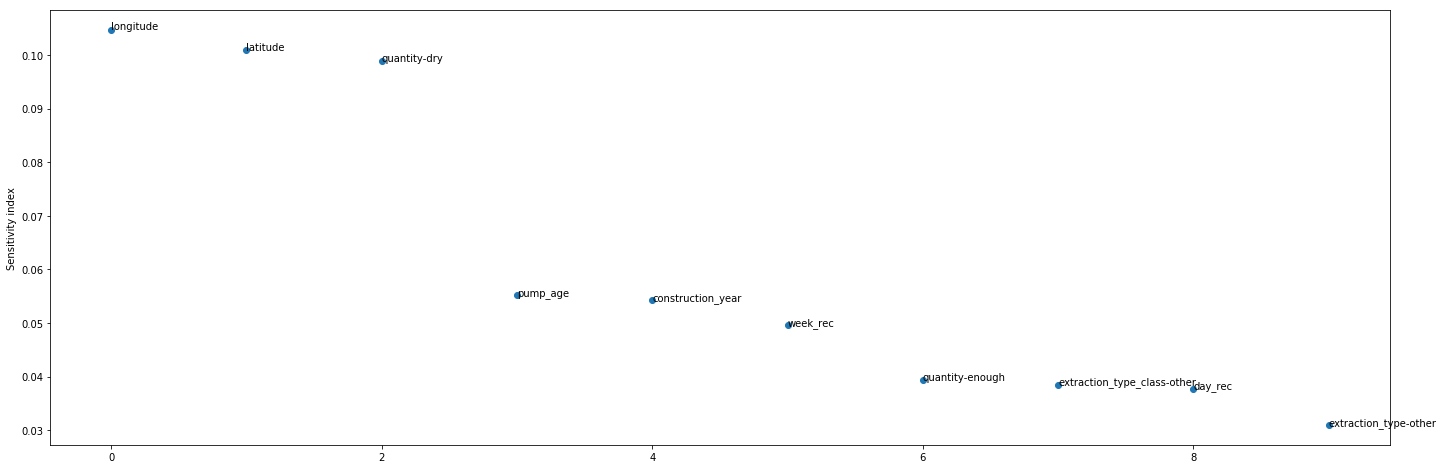

In [39]:
# Plotting most important features
num_top_features = 10
feature_importance = modelXGB.feature_importances_

feature_importances_sorted_f_importance = sorted(zip(X_trans_names, feature_importance),
                             key=lambda x:x[-1],
                             reverse=True)
fig, axe = plt.subplots(1,1)
axe.plot([elm[-1] for elm in sorted_f_importance][:num_top_features], 'o')

for (id, (f_name, f_importance)) in enumerate(sorted_f_importance[:num_top_features]):
    axe.annotate('{}'.format(f_name),xy=(id, f_importance))
axe.set_ylabel('Sensitivity index')
fig = plt.gcf()
fig.set_size_inches(24,8)

Random Forest 0.8201459034792368
Decision Tree 0.7122895622895623
Extra Trees 0.8201459034792368
XGBoost 0.8173400673400674


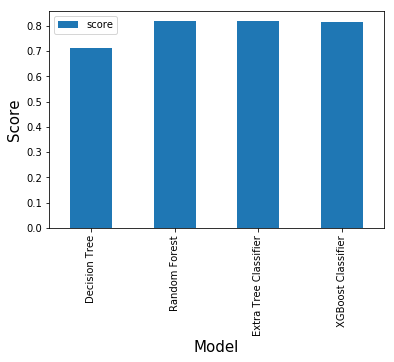

In [40]:
# Plotting the scores between different models

print ('Random Forest' ,scoreRFC)
print ('Decision Tree', scoreDTC)
print ('Extra Trees', scoreETC)
print('XGBoost', scoreXGB)


pd.DataFrame([
    ("Decision Tree", scoreDTC),
    ("Random Forest", scoreRFC),
    ("Extra Tree Classifier", scoreETC),
    ("XGBoost Classifier", scoreXGB),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="bar", fontsize=10)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.show()